## Import Required Libraries

In [390]:
import pandas as pd
import numpy as np
import mat73
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from pymultitaper import multitaper_spectrogram, plot_spectrogram

## Data Reading and PreProcessing

In [391]:
# Load .mat file
data = mat73.loadmat('./lfpUCLAC.mat')["lfpUCLAC"]
#data = mat73.loadmat('lfpUCLAC.mat')["lfpUCLAC"]
# Turn seizure data into a DataFrame
data = np.concatenate((data[:, :2], data[:, 11:]), axis=1)
column_names = ["Animal", "Session"]
column_names += [f"SZ_{i}" for i in range(11, 36012)]
seizure = pd.DataFrame(data, columns=column_names)
# Read Meta Data
#metadata = pd.read_csv("ADszNov7v21LeoIv2(in).csv")
metadata = pd.read_csv("./ADszNov7v21LeoIv3.csv")
# Merge two DataFrames
dataset = pd.merge(metadata, seizure, on=["Animal", "Session"], how='inner')

In [392]:
dataset

,Animal,Session,group,BaseStart,BaseEnd,NoSzstart2,NoSzend2,SzArtifactStart,SzArtifactEnd,SeizureStart,...,SZ_36002,SZ_36003,SZ_36004,SZ_36005,SZ_36006,SZ_36007,SZ_36008,SZ_36009,SZ_36010,SZ_36011
0,8790,2,1,-60.0,-20.0,6.0,120,-21.00,0,3.3,...,0.895588,0.866927,1.000345,1.083360,1.033944,0.890641,0.746350,0.860990,0.699898,0.401434
1,8799,2,1,-60.0,-11.0,30.0,120,-12.00,0,20.5,...,0.128512,0.141584,0.138678,0.087841,0.079126,0.025384,0.067505,-0.051598,0.006501,0.070409
2,12224,2,1,-60.0,-8.0,13.0,120,-7.50,0,8.5,...,0.009078,-0.023774,-0.006766,0.009076,-0.015155,-0.015389,0.014666,-0.004905,-0.014225,0.013500
3,12233,2,1,-60.0,-3.0,30.0,120,-2.00,0,10.0,...,0.001998,-0.022745,0.031218,-0.214643,0.020953,0.060175,-0.098818,0.052542,-0.026954,-0.019320
4,12234,2,1,-60.0,-2.0,39.0,120,-1.00,0,12.0,...,0.193024,-0.020621,0.196557,0.332058,0.345042,0.281896,0.317190,0.327150,0.339630,0.317448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,12233,19,1,0.0,0.0,20.0,89,0.65,0,9.2,...,0.016741,0.099218,-0.023653,0.102346,0.103549,-0.060198,0.098502,0.002803,-0.011623,0.046087
165,8793,19,2,-60.0,-37.0,28.5,120,0.00,0,2.6,...,-0.588621,-0.241770,0.429002,0.486332,0.377403,0.214010,0.007618,0.050616,-0.045414,0.133745
166,8797,19,2,-60.0,-53.0,40.0,120,0.00,0,3.3,...,0.074535,-0.049774,-0.050855,0.014002,0.137230,0.119934,0.122096,0.004272,0.018324,0.037781
167,12227,19,2,-60.0,-3.0,46.0,120,0.40,0,8.8,...,0.420122,0.379910,0.380465,0.387676,0.385735,0.359945,0.362996,0.341087,0.320843,0.318070


In [393]:
# Design the bandpass filter
b, a = butter(8, [4, 40], 
              btype='bandpass', fs=200)

# Apply zero-phase filtering
rawlfp = dataset.loc[:, "SZ_11":]
rawlfp = zscore(rawlfp, axis=1)
for lfp_in in range(rawlfp.shape[0]):
    min_lfp = np.min(rawlfp[lfp_in,:])
    max_lfp = np.max(rawlfp[lfp_in,:])
    rawlfp[lfp_in,:] = rawlfp[lfp_in,:] - min_lfp / (max_lfp - min_lfp) * 10
fast = filtfilt(b, a, rawlfp)



In [394]:
print(fast.dtype, fast.shape)
print(rawlfp.shape)

float64 (169, 36001)
(169, 36001)


In [395]:
# Compute the multitaper spectrogram
fs = 200
psdWindowStep = 0.2
freqs, times, psd = multitaper_spectrogram(fast[1,:], fs, time_step=psdWindowStep, 
                                           window_length=1.0, NW=4)


In [396]:
low_freq = 5   # Hz
high_freq = 35 # Hz
def bandpass_filter_spectrogram(freqs, psd, low_freq, high_freq):
    """Extract only the desired frequency range from spectrogram"""
    # Find frequency indices
    freq_indices = (freqs >= low_freq) & (freqs <= high_freq)
    
    # Extract bandpass frequencies and PSD
    freqs_bp = freqs[freq_indices]
    psd_bp = psd[freq_indices,:]
    
    return freqs_bp, psd_bp


In [397]:
def zscorepsd_data(datapsd):
    datapsd = zscore(datapsd, axis=None)
    min_psd = np.min(datapsd)
    max_psd = np.max(datapsd)
    datapsd = datapsd - min_psd / (max_psd - min_psd) * 10
    return datapsd

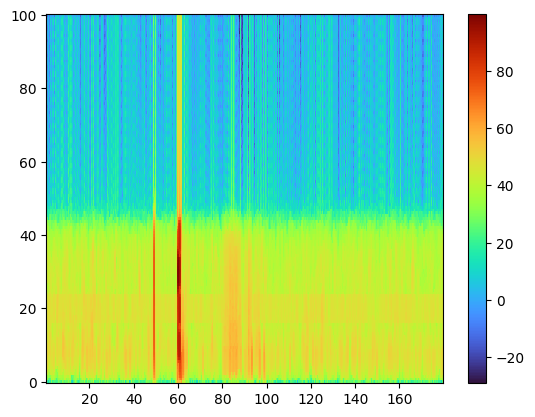

(129, 896) (129,) (896,)
(38, 896) (38,) (896,)


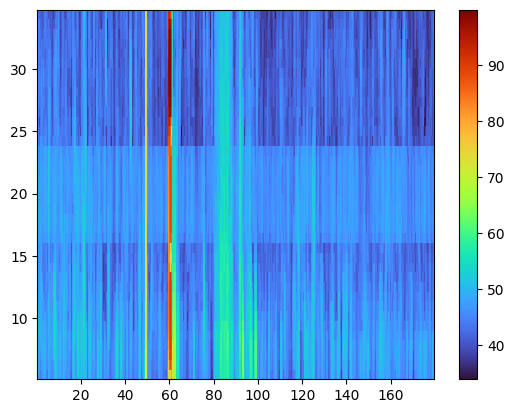

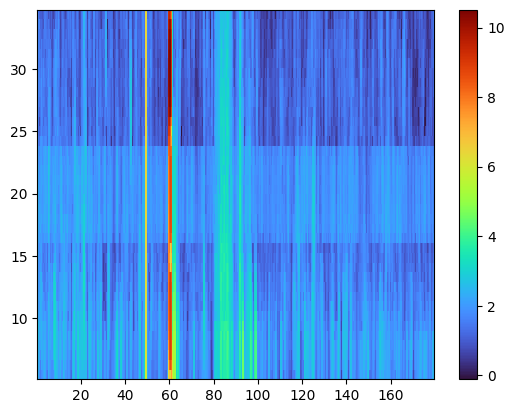

In [398]:
# Parameters
fs = 200
freq_indices = (freqs >= low_freq) & (freqs <= high_freq)
# Get dimensions from first row to initialize the 3D matrix
freqs, times, psd_temp = multitaper_spectrogram(fast[1,:], fs, time_step=psdWindowStep, 
                                                window_length=1.0, NW=4)

plt.pcolormesh(times, freqs, psd_temp, cmap = 'turbo', shading='auto')
plt.colorbar()
plt.show()
print(psd_temp.shape, freqs.shape, times.shape)
#print(times,freqs)
freqsFilt, psd_tempFilt = bandpass_filter_spectrogram(freqs, psd_temp, low_freq, high_freq) 
print(psd_tempFilt.shape, freqsFilt.shape, times.shape)
#print(times, freqsFilt)
plt.pcolormesh(times, freqsFilt, psd_tempFilt, cmap = 'turbo', shading='auto')
plt.colorbar()
plt.show()
psd_tempFilt = zscorepsd_data(psd_tempFilt)

plt.pcolormesh(times, freqsFilt, psd_tempFilt, cmap = 'turbo', shading='auto')
plt.colorbar()
plt.show()


In [399]:
# Initialize 3D matrix: (n_sessions, n_freqs, n_times)
n_sessions = fast.shape[0]
n_freqs = len(freqsFilt)
n_times = len(times)
psd_3d = np.zeros((n_sessions, n_freqs, n_times))

print(f"Processing {n_sessions} sessions...")
print(f"PSD matrix shape will be: ({n_sessions}, {n_freqs}, {n_times})")

# Loop through all rows (sessions)
for session in range(n_sessions):
    print(f"Processing session {session + 1}/{n_sessions}")
    
    # Get spectrogram for this session
    freqs, times,  psd = multitaper_spectrogram(fast[session,:], fs, time_step=psdWindowStep, 
                                               window_length=1.0, NW=4)
    
    # Convert to log scale
    #psd = np.interp(psd, (psd.min(), psd.max()), (0, 10))
    #psd_log = 10 * np.log10(psd)
    #psd_log = np.interp(psd_log, (psd_log.min(), psd_log.max()), (0, 10))
    
    freqs, psd = bandpass_filter_spectrogram(freqs, psd, low_freq, high_freq)
    psd = zscorepsd_data(psd)
    #psd_log = np.interp(psd_log, (psd_log.min(), psd_log.max()), (0, 100))
    # Store in 3D matrix
    
    psd_3d[session, :, :] = psd

print("Done! 3D PSD matrix created.")
print(f"Final shape: {psd_3d.shape}")
print(f"Shape interpretation: (sessions={psd_3d.shape[0]}, freqs={psd_3d.shape[1]}, times={psd_3d.shape[2]})")

Processing 169 sessions...
PSD matrix shape will be: (169, 38, 896)
Processing session 1/169
Processing session 2/169
Processing session 3/169
Processing session 4/169
Processing session 5/169
Processing session 6/169
Processing session 7/169
Processing session 8/169
Processing session 9/169
Processing session 10/169
Processing session 11/169
Processing session 12/169
Processing session 13/169
Processing session 14/169
Processing session 15/169
Processing session 16/169
Processing session 17/169
Processing session 18/169
Processing session 19/169
Processing session 20/169
Processing session 21/169
Processing session 22/169
Processing session 23/169
Processing session 24/169
Processing session 25/169
Processing session 26/169
Processing session 27/169
Processing session 28/169
Processing session 29/169
Processing session 30/169
Processing session 31/169
Processing session 32/169
Processing session 33/169
Processing session 34/169
Processing session 35/169
Processing session 36/169
Proce

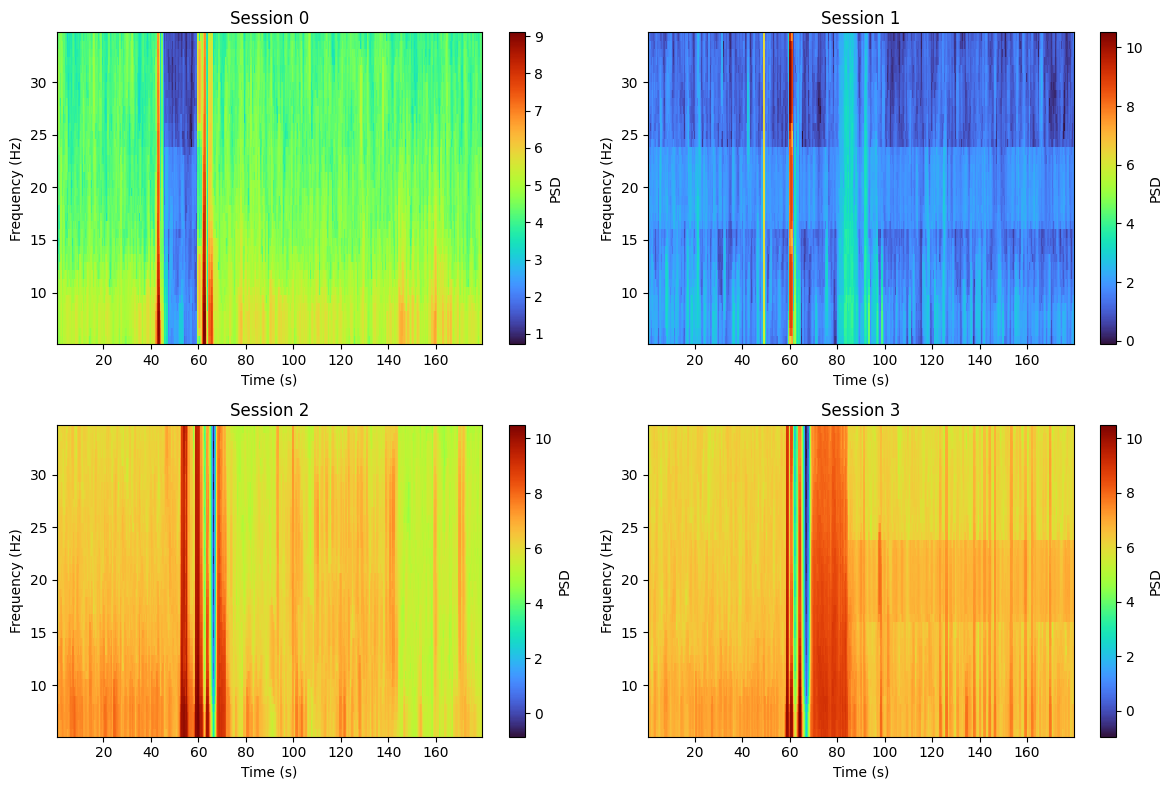

In [400]:
# Example: Plot a few channels
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i in range(min(4, n_sessions)):  # Plot first 4 channels
    im = axes[i].pcolormesh(times, freqs, psd_3d[i], cmap = 'turbo', shading='auto')
    axes[i].set_title(f'Session {i}')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Frequency (Hz)')
    plt.colorbar(im, ax=axes[i], label='PSD')

plt.tight_layout()
plt.show()


In [401]:
#times -= 60
psd_3d[2,:,:].min()
print(psd_3d.shape)

(169, 38, 896)


In [402]:
import math
def time2index(time, start, psdWindowStep):
    return math.floor((time - start) / psdWindowStep)

In [403]:
start = -60
times_to_convert = ["BaseStart", "BaseEnd","SeizureStart", "SeizureEnd", "SzArtifactStart", "SzArtifactEnd"]
for column_name in times_to_convert:
    dataset[column_name] = dataset[column_name].apply(lambda x: time2index(x, start=start, psdWindowStep=psdWindowStep))
    #dataset[column_name] = dataset[column_name].astype(int)

In [404]:
print(metadata.Animal.dtype)
print(dataset.loc[:,"Animal"].dtype)
print(psd_3d.shape)

int64
int64
(169, 38, 896)


In [405]:
def extract_samples(idx, time_row):        
    time_row = time_row.astype(int)
    base = psd_3d[idx, :, time_row["BaseStart"]: time_row["BaseEnd"]]
    seizure = psd_3d[idx, :, time_row["SeizureStart"]: time_row["SeizureEnd"]]
    artifact = psd_3d[idx, :, time_row["SzArtifactStart"]: time_row["SzArtifactEnd"]]
    return base.T, seizure.T, artifact.T

In [ ]:
feature_dim = psd_3d.shape[1] 
animalID = 8790
all_base = np.empty((0, feature_dim))
all_seizure = np.empty((0, feature_dim))
all_artifact = np.empty((0, feature_dim))
# animal id = 8790, 8799, 8800, 8798, 8797, 12233, 12234, 12226, 12227, 12228, 12229, 12224

for i in range(len(dataset)):
    #if dataset.loc[i,"Animal"]==animalID:
    base, seizure, artifact = extract_samples(i, dataset.loc[i, times_to_convert])
    all_base = np.concatenate((all_base, base), axis=0)
    all_seizure = np.concatenate((all_seizure, seizure), axis=0)
    all_artifact = np.concatenate((all_artifact, artifact), axis=0)

In [407]:
BASE_LABEL = 0
ARTIFACT_LABEL = 1
SEIZURE_LABEL = 2

In [408]:
base_label_arr = np.ones(shape=(len(all_base), 1)) * BASE_LABEL
artifact_label_arr = np.ones(shape=(len(all_artifact), 1)) * ARTIFACT_LABEL
seizure_label_arr = np.ones(shape=(len(all_seizure), 1)) * SEIZURE_LABEL

In [409]:
all_base = np.concatenate((all_base, base_label_arr), axis=1)
all_artifact = np.concatenate((all_artifact, artifact_label_arr), axis=1)
all_seizure = np.concatenate((all_seizure, seizure_label_arr), axis=1)

In [410]:
print(all_seizure.shape,all_base.shape)

(0, 39) (0, 39)


In [411]:
all_data = np.concatenate((all_base, all_artifact, all_seizure), axis=0)
all_data.shape

(0, 39)

In [412]:
np.random.shuffle(all_data)
all_data.shape

(0, 39)

# Modelling

## Imports

In [413]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.datasets import load_iris
import scipy
from tqdm import tqdm
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import math
import copy


## Helper Functions

In [414]:
def plot_train_val_test_accuracy(train_acc, val_acc, test_acc):
  epochs = list(range(1, len(train_acc) + 1))

    # Create the figure
  fig = go.Figure()

    # Add traces
  fig.add_trace(
        go.Scatter(
            x=epochs,
            y=train_acc,
            name="Train Accuracy",
            mode='lines',
            line=dict(color='#8b5cf6', width=2),
            hovertemplate="Epoch %{x}<br>Accuracy: %{y:.4f}<extra></extra>"
        )
    )

  fig.add_trace(
        go.Scatter(
            x=epochs,
            y=val_acc,
            name="Validation Accuracyy",
            mode='lines',
            line=dict(color='#22c55e', width=2),
            hovertemplate="Epoch %{x}<br>Accuracy: %{y:.4f}<extra></extra>"
        )
    )

  fig.add_trace(
        go.Scatter(
            x=epochs,
            y=test_acc,
            name="Test Accuracyy",
            mode='lines',
            line=dict(color='#800080', width=2),
            hovertemplate="Epoch %{x}<br>Accuracy: %{y:.4f}<extra></extra>"
        )
    )


    # Update layout
  fig.update_layout(
        title=dict(
            text="Training, Validation and Test Accuracy over Epochs",
            x=0.5,
            y=0.95,
            xanchor='center',
            yanchor='top'
        ),
        xaxis_title="Epochs",
        yaxis_title="Accuracy",
        hovermode='x unified',
        template='plotly_white',
        xaxis=dict(
            tickmode='linear',
            tick0=1,
            dtick=max(1, len(epochs) // 10)  # Show ~10 ticks on x-axis
        ),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )

  fig.show()


In [415]:
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [416]:
# @title Set device (GPU or CPU).
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [417]:
SEED = 42
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 42 has been set.
GPU is enabled in this notebook.


## Model Definition

In [418]:
class FFN(nn.Module):

    @staticmethod
    def he_uniform_init(layer):
        """
        Apply He Uniform Initialization to the layer's weights and optionally biases
        """
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)  # common practice is to zero biases

    def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num, has_batch_norm=True):
        """
        Initialize Feed-Forward Network parameters
        """
        super(FFN, self).__init__()
        self.input_feature_num = input_feature_num
        self.ffn = nn.Sequential()
        in_num = input_feature_num

        for layer_index, out_num in enumerate(hidden_unit_nums):
            layer = nn.Linear(in_num, out_num, bias=True)
            self.he_uniform_init(layer)  # Apply He initialization here
            self.ffn.add_module(f"Linear_{layer_index}", layer)

            # Batch Normalization Layer
            if has_batch_norm:
                self.ffn.add_module(f"BatchNorm_{layer_index}", nn.BatchNorm1d(out_num))

            actv_layer = eval(f"nn.{actv}")  
            self.ffn.add_module(f"Activation_{layer_index}", actv_layer)

            in_num = out_num

        out_layer = nn.Linear(in_num, output_feature_num, bias=True)
        self.he_uniform_init(out_layer)  
        self.ffn.add_module(f'Linear_{len(hidden_unit_nums)}', out_layer)

    def forward(self, x):
        x = x.view(-1, self.input_feature_num)
        return self.ffn(x)


## Defining DataLoaders

In [419]:
X = all_data[:, :-1]  # features 
y = all_data[:, -1]   # labels  

# Split using sklearn
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=SEED)
# Convert to tensors
X_train_tensor, y_train_tensor = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)  # or float32 for regression
X_val_tensor, y_val_tensor = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)
X_test_tensor, y_test_tensor = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)

# Wrap in TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

ValueError: With n_samples=0, test_size=0.1 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
batch_size = 512
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

def get_data_loaders(train_dataset, val_dataset, test_dataset):

  train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed,
                          )


  val_loader = DataLoader(val_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                        )

  test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                        )
  return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset)

## Training Loop

In [ ]:
def get_model_accuracy(net, data_loader, device=DEVICE):
  correct = 0
  net.eval()  # Set model to evaluation mode
  with torch.no_grad():  # No need to track gradients
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      y_pred = torch.argmax(net(inputs), dim=1)
      correct += (labels == y_pred).sum().item()
  accuracy = (correct / len(data_loader.dataset)) * 100
  return accuracy


def get_loss(net, criterion, data_loader, device=DEVICE):
    net.eval() #Set model to evaluation mode
    with torch.no_grad():
        running_loss = 0.0
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(data_loader)




def train_eval_model(net, criterion, optimizer, train_loader, valid_loader, test_loader, num_epochs, validation_freq, verbose=True, device=DEVICE):
    net.to(device)
    training_accuracy, validation_accuracy, test_accuracy = [], [], []
    for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
        net.train()
        running_loss = 0.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # add current loss to running_loss
            running_loss += loss.detach().item()
        train_loss = running_loss / len(train_loader)
        if verbose:
          print(f"Epoch {epoch}: Train Loss {train_loss}")
        # save accuracy and loss for plotting
        if epoch % validation_freq == 0:
            validation_accuracy.append(get_model_accuracy(net, valid_loader))
            test_accuracy.append(get_model_accuracy(net, test_loader))
            training_accuracy.append(get_model_accuracy(net, train_loader))
    return net, training_accuracy, validation_accuracy, test_accuracy


In [ ]:
actv = "ReLU()"
input_feature_num = feature_dim
hidden_unit_nums = [4096, 2048, 1024, 512, 256, 128]
output_feature_num = 3
max_epochs = 300
criterion = nn.CrossEntropyLoss()
mlp = FFN(actv, input_feature_num, hidden_unit_nums, output_feature_num)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

In [ ]:
net, train_acc, valid_acc, test_acc = train_eval_model(mlp, criterion, optimizer, train_loader, val_loader, test_loader, max_epochs, validation_freq=10)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 0: Train Loss 0.4874963201582432


  1%|▏         | 4/300 [00:00<00:18, 16.42it/s]

Epoch 1: Train Loss 0.1072981742521127
Epoch 2: Train Loss 0.10977506761749585
Epoch 3: Train Loss 0.08754773313800494
Epoch 4: Train Loss 0.07421144532660644


  3%|▎         | 8/300 [00:00<00:16, 17.68it/s]

Epoch 5: Train Loss 0.0696029718965292
Epoch 6: Train Loss 0.05870953636864821
Epoch 7: Train Loss 0.061091143948336445
Epoch 8: Train Loss 0.07941245846450329


  4%|▍         | 12/300 [00:00<00:16, 17.07it/s]

Epoch 9: Train Loss 0.05935899789134661
Epoch 10: Train Loss 0.05381395978232225
Epoch 11: Train Loss 0.04875841240088145


  5%|▌         | 16/300 [00:01<00:21, 13.32it/s]

Epoch 12: Train Loss 0.04429334029555321
Epoch 13: Train Loss 0.038103253580629826
Epoch 14: Train Loss 0.03748097798476616
Epoch 15: Train Loss 0.05517082071552674


  7%|▋         | 20/300 [00:01<00:18, 15.53it/s]

Epoch 16: Train Loss 0.045076328329741955
Epoch 17: Train Loss 0.04105582181364298
Epoch 18: Train Loss 0.03103856338808934
Epoch 19: Train Loss 0.023722631856799126


  8%|▊         | 24/300 [00:01<00:16, 16.29it/s]

Epoch 20: Train Loss 0.022480671604474384
Epoch 21: Train Loss 0.0304843676276505
Epoch 22: Train Loss 0.029156757208208244
Epoch 23: Train Loss 0.024130027430752914


  9%|▉         | 28/300 [00:01<00:15, 17.28it/s]

Epoch 24: Train Loss 0.019926143810153008
Epoch 25: Train Loss 0.018638288291792076
Epoch 26: Train Loss 0.014613576388607422
Epoch 27: Train Loss 0.013980009903510412


 11%|█         | 32/300 [00:02<00:15, 16.88it/s]

Epoch 28: Train Loss 0.02240356244146824
Epoch 29: Train Loss 0.014452869538217783
Epoch 30: Train Loss 0.0190844195894897
Epoch 31: Train Loss 0.02442168879012267


 12%|█▏        | 36/300 [00:02<00:15, 17.58it/s]

Epoch 32: Train Loss 0.03040233456219236
Epoch 33: Train Loss 0.02195614669471979
Epoch 34: Train Loss 0.023162923520430923
Epoch 35: Train Loss 0.02529885961363713


 13%|█▎        | 40/300 [00:02<00:14, 17.92it/s]

Epoch 36: Train Loss 0.01916889954979221
Epoch 37: Train Loss 0.01642143268448611
Epoch 38: Train Loss 0.014431351019690434
Epoch 39: Train Loss 0.013409515221913656


 15%|█▍        | 44/300 [00:02<00:14, 17.50it/s]

Epoch 40: Train Loss 0.0102686807513237
Epoch 41: Train Loss 0.010749991944370171
Epoch 42: Train Loss 0.009320095181465149
Epoch 43: Train Loss 0.010401629144325852


 16%|█▌        | 48/300 [00:02<00:14, 17.90it/s]

Epoch 44: Train Loss 0.007443872202808659
Epoch 45: Train Loss 0.007275532775868972
Epoch 46: Train Loss 0.00850108494826903
Epoch 47: Train Loss 0.005486266338266432


 17%|█▋        | 52/300 [00:03<00:14, 17.21it/s]

Epoch 48: Train Loss 0.006557694578077644
Epoch 49: Train Loss 0.007063168780102084
Epoch 50: Train Loss 0.009283216670155525
Epoch 51: Train Loss 0.008173404804741343


 19%|█▊        | 56/300 [00:03<00:13, 17.77it/s]

Epoch 52: Train Loss 0.010730578564107418
Epoch 53: Train Loss 0.00970356484564642
Epoch 54: Train Loss 0.00793270425250133
Epoch 55: Train Loss 0.006253269966691732


 20%|██        | 60/300 [00:03<00:13, 18.02it/s]

Epoch 56: Train Loss 0.006932506337761879
Epoch 57: Train Loss 0.007268147853513558
Epoch 58: Train Loss 0.012933168094605207
Epoch 59: Train Loss 0.017880012126018602


 21%|██▏       | 64/300 [00:03<00:13, 17.45it/s]

Epoch 60: Train Loss 0.018034001579508185
Epoch 61: Train Loss 0.02206551128377517
Epoch 62: Train Loss 0.01728816470131278
Epoch 63: Train Loss 0.01439902683099111


 23%|██▎       | 68/300 [00:04<00:12, 17.92it/s]

Epoch 64: Train Loss 0.013368328024322787
Epoch 65: Train Loss 0.011886326014064252
Epoch 66: Train Loss 0.01262634270824492
Epoch 67: Train Loss 0.0093267773433278


 24%|██▍       | 72/300 [00:04<00:13, 17.10it/s]

Epoch 68: Train Loss 0.006837128855598469
Epoch 69: Train Loss 0.009158761124126613
Epoch 70: Train Loss 0.005157881416380405
Epoch 71: Train Loss 0.005279217769081394


 25%|██▌       | 76/300 [00:04<00:12, 17.66it/s]

Epoch 72: Train Loss 0.004510666146719207
Epoch 73: Train Loss 0.00346027526150768
Epoch 74: Train Loss 0.0029149729816708714
Epoch 75: Train Loss 0.002980134052146847


 27%|██▋       | 80/300 [00:04<00:12, 17.96it/s]

Epoch 76: Train Loss 0.003183463520448034
Epoch 77: Train Loss 0.00247482613970836
Epoch 78: Train Loss 0.0026633029143946865
Epoch 79: Train Loss 0.0026275499064164856


 28%|██▊       | 84/300 [00:04<00:12, 17.47it/s]

Epoch 80: Train Loss 0.002090959023917094
Epoch 81: Train Loss 0.0023669344858111194
Epoch 82: Train Loss 0.002074695754951487
Epoch 83: Train Loss 0.0019085734869198252


 29%|██▉       | 88/300 [00:05<00:11, 17.81it/s]

Epoch 84: Train Loss 0.0023324833455262706
Epoch 85: Train Loss 0.0020872317157530538
Epoch 86: Train Loss 0.0027316784738407782
Epoch 87: Train Loss 0.0028280074669358632


 31%|███       | 92/300 [00:05<00:12, 17.12it/s]

Epoch 88: Train Loss 0.003094894617485503
Epoch 89: Train Loss 0.004439602101532121
Epoch 90: Train Loss 0.0028020159127966813
Epoch 91: Train Loss 0.002993822631348545


 32%|███▏      | 96/300 [00:05<00:11, 17.72it/s]

Epoch 92: Train Loss 0.002766290587411883
Epoch 93: Train Loss 0.002102723611945597
Epoch 94: Train Loss 0.0024098423503649733
Epoch 95: Train Loss 0.002219335365225561


 33%|███▎      | 100/300 [00:05<00:11, 18.03it/s]

Epoch 96: Train Loss 0.002218331370386295
Epoch 97: Train Loss 0.006442865735152736
Epoch 98: Train Loss 0.008931783871958032
Epoch 99: Train Loss 0.010332757025025785


 35%|███▍      | 104/300 [00:06<00:11, 17.53it/s]

Epoch 100: Train Loss 0.013238453771919012
Epoch 101: Train Loss 0.009888405484768251
Epoch 102: Train Loss 0.011488816312824687
Epoch 103: Train Loss 0.007198828000885745


 36%|███▌      | 108/300 [00:06<00:10, 17.92it/s]

Epoch 104: Train Loss 0.005402195383794606
Epoch 105: Train Loss 0.005334848014172167
Epoch 106: Train Loss 0.003798197334011396
Epoch 107: Train Loss 0.0031246955234867833


 37%|███▋      | 112/300 [00:06<00:10, 17.23it/s]

Epoch 108: Train Loss 0.0032326760701835155
Epoch 109: Train Loss 0.0025835420868437118
Epoch 110: Train Loss 0.0030818377854302526
Epoch 111: Train Loss 0.002697064793513467


 39%|███▊      | 116/300 [00:06<00:10, 17.64it/s]

Epoch 112: Train Loss 0.0026592984601544836
Epoch 113: Train Loss 0.002940025161175678
Epoch 114: Train Loss 0.0023719709812818715
Epoch 115: Train Loss 0.005149857223538372


 40%|████      | 120/300 [00:06<00:10, 17.99it/s]

Epoch 116: Train Loss 0.005384501438432683
Epoch 117: Train Loss 0.004272624893928878
Epoch 118: Train Loss 0.00406911342482393
Epoch 119: Train Loss 0.006783838233483645


 41%|████▏     | 124/300 [00:07<00:10, 17.37it/s]

Epoch 120: Train Loss 0.0035225540438356497
Epoch 121: Train Loss 0.003727531618399856
Epoch 122: Train Loss 0.004146078291038672
Epoch 123: Train Loss 0.005765635597830017


 43%|████▎     | 128/300 [00:07<00:09, 17.82it/s]

Epoch 124: Train Loss 0.005150947617948987
Epoch 125: Train Loss 0.0040436194006664055
Epoch 126: Train Loss 0.0037201729331475994
Epoch 127: Train Loss 0.0037183715806653104


 44%|████▍     | 132/300 [00:07<00:09, 17.13it/s]

Epoch 128: Train Loss 0.003116348782593074
Epoch 129: Train Loss 0.0023144831454070904
Epoch 130: Train Loss 0.002959020896620738
Epoch 131: Train Loss 0.002590261210571043


 45%|████▌     | 136/300 [00:07<00:09, 17.72it/s]

Epoch 132: Train Loss 0.0020519996129830056
Epoch 133: Train Loss 0.001814757570779572
Epoch 134: Train Loss 0.0017594466989976354
Epoch 135: Train Loss 0.002011538051495639


 47%|████▋     | 140/300 [00:08<00:08, 18.01it/s]

Epoch 136: Train Loss 0.0030248161007572585
Epoch 137: Train Loss 0.008658435581310187
Epoch 138: Train Loss 0.004358127422165126
Epoch 139: Train Loss 0.0026352581286725276


 48%|████▊     | 144/300 [00:08<00:08, 17.45it/s]

Epoch 140: Train Loss 0.002948805044676798
Epoch 141: Train Loss 0.0027458915137685835
Epoch 142: Train Loss 0.002147689912817441
Epoch 143: Train Loss 0.002589781016771061


 49%|████▉     | 148/300 [00:08<00:08, 17.84it/s]

Epoch 144: Train Loss 0.0022110626183954687
Epoch 145: Train Loss 0.0025741719703849717
Epoch 146: Train Loss 0.0023313530788679295
Epoch 147: Train Loss 0.0024521596351405606


 51%|█████     | 152/300 [00:08<00:08, 17.18it/s]

Epoch 148: Train Loss 0.0027124748594360426
Epoch 149: Train Loss 0.0016967744183299753
Epoch 150: Train Loss 0.0017342042386493024
Epoch 151: Train Loss 0.0017767765481645863


 52%|█████▏    | 156/300 [00:09<00:08, 17.74it/s]

Epoch 152: Train Loss 0.0017754862152893718
Epoch 153: Train Loss 0.0018871325495031972
Epoch 154: Train Loss 0.0018455950436570372
Epoch 155: Train Loss 0.0018267937824324083


 53%|█████▎    | 160/300 [00:09<00:07, 17.97it/s]

Epoch 156: Train Loss 0.0015803239487771255
Epoch 157: Train Loss 0.0017590146793130164
Epoch 158: Train Loss 0.002073862466204446
Epoch 159: Train Loss 0.0014731434202985838
Epoch 160: Train Loss 0.001867976097855717


 55%|█████▍    | 164/300 [00:09<00:09, 13.91it/s]

Epoch 161: Train Loss 0.0014012227135632809
Epoch 162: Train Loss 0.0017319285737661023
Epoch 163: Train Loss 0.0015469303204251144
Epoch 164: Train Loss 0.0014951510080815449


 56%|█████▌    | 168/300 [00:09<00:08, 15.86it/s]

Epoch 165: Train Loss 0.0018577491185472657
Epoch 166: Train Loss 0.001946008039036921
Epoch 167: Train Loss 0.0016041956550907344
Epoch 168: Train Loss 0.002416854571492877


 57%|█████▋    | 172/300 [00:10<00:07, 16.21it/s]

Epoch 169: Train Loss 0.002024662502662977
Epoch 170: Train Loss 0.0015791412321656633
Epoch 171: Train Loss 0.0022213160361085706
Epoch 172: Train Loss 0.0017539411225394967


 59%|█████▊    | 176/300 [00:10<00:07, 17.23it/s]

Epoch 173: Train Loss 0.001985441140277544
Epoch 174: Train Loss 0.001955085533457653
Epoch 175: Train Loss 0.0022271446808493542
Epoch 176: Train Loss 0.0017657724189727257


 60%|██████    | 180/300 [00:10<00:06, 17.75it/s]

Epoch 177: Train Loss 0.001585142334079137
Epoch 178: Train Loss 0.0016732121124126327
Epoch 179: Train Loss 0.0020621160389661477
Epoch 180: Train Loss 0.0017988992597868976


 61%|██████▏   | 184/300 [00:10<00:06, 17.47it/s]

Epoch 181: Train Loss 0.0018161477504084662
Epoch 182: Train Loss 0.0016620937688761235
Epoch 183: Train Loss 0.001481180711076983
Epoch 184: Train Loss 0.0016127131687729464


 63%|██████▎   | 188/300 [00:10<00:06, 17.97it/s]

Epoch 185: Train Loss 0.0020129732620262075
Epoch 186: Train Loss 0.0015637515413497265
Epoch 187: Train Loss 0.0018639829116485391
Epoch 188: Train Loss 0.0026067156407710477


 64%|██████▍   | 192/300 [00:11<00:06, 17.23it/s]

Epoch 189: Train Loss 0.013057190992791826
Epoch 190: Train Loss 0.005762929181704142
Epoch 191: Train Loss 0.013847950496710837
Epoch 192: Train Loss 0.020633775546836357


 65%|██████▌   | 196/300 [00:11<00:05, 17.80it/s]

Epoch 193: Train Loss 0.02151553361909464
Epoch 194: Train Loss 0.02320984456067284
Epoch 195: Train Loss 0.0332783890577654
Epoch 196: Train Loss 0.03142410144209862


 67%|██████▋   | 200/300 [00:11<00:05, 18.08it/s]

Epoch 197: Train Loss 0.017921298897514742
Epoch 198: Train Loss 0.014555054173494378
Epoch 199: Train Loss 0.009626650949940085
Epoch 200: Train Loss 0.009407681412994862


 68%|██████▊   | 204/300 [00:11<00:05, 17.57it/s]

Epoch 201: Train Loss 0.00686672826608022
Epoch 202: Train Loss 0.007582848658785224
Epoch 203: Train Loss 0.0055833397394356625
Epoch 204: Train Loss 0.005773636512458324


 69%|██████▉   | 208/300 [00:12<00:05, 17.97it/s]

Epoch 205: Train Loss 0.004578909875514607
Epoch 206: Train Loss 0.005091686694261928
Epoch 207: Train Loss 0.00329028880999734
Epoch 208: Train Loss 0.003067945537623018


 71%|███████   | 212/300 [00:12<00:05, 17.20it/s]

Epoch 209: Train Loss 0.0035221037008644394
Epoch 210: Train Loss 0.0034828494923810163
Epoch 211: Train Loss 0.00385024652738745
Epoch 212: Train Loss 0.006402652288670652


 72%|███████▏  | 216/300 [00:12<00:04, 17.76it/s]

Epoch 213: Train Loss 0.0037010715362460664
Epoch 214: Train Loss 0.0038563902489840984
Epoch 215: Train Loss 0.005447574231463174
Epoch 216: Train Loss 0.0032088777516037226


 73%|███████▎  | 220/300 [00:12<00:04, 18.09it/s]

Epoch 217: Train Loss 0.006261011216944705
Epoch 218: Train Loss 0.005017517561403413
Epoch 219: Train Loss 0.0036929349007550627
Epoch 220: Train Loss 0.0031623420897327983


 75%|███████▍  | 224/300 [00:13<00:04, 17.57it/s]

Epoch 221: Train Loss 0.005338480230420828
Epoch 222: Train Loss 0.008190196298528463
Epoch 223: Train Loss 0.005038150042916338
Epoch 224: Train Loss 0.00594452671551456


 76%|███████▌  | 228/300 [00:13<00:04, 17.97it/s]

Epoch 225: Train Loss 0.00534601693895335
Epoch 226: Train Loss 0.005098762611548106
Epoch 227: Train Loss 0.013466477355298897
Epoch 228: Train Loss 0.01212208264041692


 77%|███████▋  | 232/300 [00:13<00:03, 17.25it/s]

Epoch 229: Train Loss 0.020392989739775658
Epoch 230: Train Loss 0.012165909827065965
Epoch 231: Train Loss 0.007927583355922252
Epoch 232: Train Loss 0.005552825789588193


 79%|███████▊  | 236/300 [00:13<00:03, 17.81it/s]

Epoch 233: Train Loss 0.0046329973653579755
Epoch 234: Train Loss 0.004647393701209997
Epoch 235: Train Loss 0.0026936919311992824
Epoch 236: Train Loss 0.003283949694984282


 80%|████████  | 240/300 [00:13<00:03, 18.08it/s]

Epoch 237: Train Loss 0.008033166484286388
Epoch 238: Train Loss 0.0039539496404662105
Epoch 239: Train Loss 0.0024548496294301003
Epoch 240: Train Loss 0.003314355213660747


 81%|████████▏ | 244/300 [00:14<00:03, 17.54it/s]

Epoch 241: Train Loss 0.0029192759636013457
Epoch 242: Train Loss 0.0034550366593369595
Epoch 243: Train Loss 0.0022659214349308363
Epoch 244: Train Loss 0.0025352401038010917


 83%|████████▎ | 248/300 [00:14<00:02, 17.87it/s]

Epoch 245: Train Loss 0.004120733530726284
Epoch 246: Train Loss 0.0028169810345085957
Epoch 247: Train Loss 0.0037895133088265234
Epoch 248: Train Loss 0.0024855802863991507


 84%|████████▍ | 252/300 [00:14<00:02, 17.19it/s]

Epoch 249: Train Loss 0.003569412154320162
Epoch 250: Train Loss 0.00402259733042835
Epoch 251: Train Loss 0.005708625249098986
Epoch 252: Train Loss 0.009093937648382658


 85%|████████▌ | 256/300 [00:14<00:02, 17.70it/s]

Epoch 253: Train Loss 0.01594663943978958
Epoch 254: Train Loss 0.010326611324368665
Epoch 255: Train Loss 0.009854851406998932
Epoch 256: Train Loss 0.010155021135384837


 87%|████████▋ | 260/300 [00:15<00:02, 17.91it/s]

Epoch 257: Train Loss 0.005099383425355579
Epoch 258: Train Loss 0.005469615765226384
Epoch 259: Train Loss 0.0031013463352185986
Epoch 260: Train Loss 0.00445556555253764


 88%|████████▊ | 264/300 [00:15<00:02, 17.39it/s]

Epoch 261: Train Loss 0.002594545929847906
Epoch 262: Train Loss 0.004323160578981818
Epoch 263: Train Loss 0.002304046783441057
Epoch 264: Train Loss 0.005761325815304493


 89%|████████▉ | 268/300 [00:15<00:01, 17.83it/s]

Epoch 265: Train Loss 0.003011392313055694
Epoch 266: Train Loss 0.0020315505753387697
Epoch 267: Train Loss 0.002210853524350872
Epoch 268: Train Loss 0.002656173067710673


 91%|█████████ | 272/300 [00:15<00:01, 17.13it/s]

Epoch 269: Train Loss 0.0018953208103387926
Epoch 270: Train Loss 0.0019237030113193516
Epoch 271: Train Loss 0.0018059406017224926
Epoch 272: Train Loss 0.0018271525004820433


 92%|█████████▏| 276/300 [00:15<00:01, 17.67it/s]

Epoch 273: Train Loss 0.0016218634167065222
Epoch 274: Train Loss 0.0022845741502048136
Epoch 275: Train Loss 0.0020383210818787725
Epoch 276: Train Loss 0.0015522890692712583


 93%|█████████▎| 280/300 [00:16<00:01, 17.88it/s]

Epoch 277: Train Loss 0.0014286980173589352
Epoch 278: Train Loss 0.001493332061121085
Epoch 279: Train Loss 0.0014453341730889708
Epoch 280: Train Loss 0.0015934039147396106


 95%|█████████▍| 284/300 [00:16<00:00, 17.39it/s]

Epoch 281: Train Loss 0.001650514523741246
Epoch 282: Train Loss 0.0016443030641918692
Epoch 283: Train Loss 0.0015447213700099383
Epoch 284: Train Loss 0.0017148772603832185


 96%|█████████▌| 288/300 [00:16<00:00, 17.68it/s]

Epoch 285: Train Loss 0.0015545102942269295
Epoch 286: Train Loss 0.0015695777353054534
Epoch 287: Train Loss 0.001583227084969015
Epoch 288: Train Loss 0.0017613203866252054


 97%|█████████▋| 292/300 [00:16<00:00, 17.04it/s]

Epoch 289: Train Loss 0.0015732934540816739
Epoch 290: Train Loss 0.0015553337428476273
Epoch 291: Train Loss 0.001341069244517712
Epoch 292: Train Loss 0.0015044459384322788


 99%|█████████▊| 296/300 [00:17<00:00, 17.60it/s]

Epoch 293: Train Loss 0.001483843352010202
Epoch 294: Train Loss 0.0015647991410029742
Epoch 295: Train Loss 0.001549087525442398
Epoch 296: Train Loss 0.0016343583029083675


100%|██████████| 300/300 [00:17<00:00, 17.32it/s]

Epoch 297: Train Loss 0.0015666382508546424
Epoch 298: Train Loss 0.0015671275238370679
Epoch 299: Train Loss 0.001449202681518121


In [ ]:
plot_train_val_test_accuracy(train_acc, valid_acc, test_acc)

In [ ]:
def get_labels(net, sessionID):
    net.eval()
    session = torch.tensor(psd_3d[sessionID,:,:], device=DEVICE, dtype=torch.float32).T
    real_out = np.zeros((psd_3d.shape[2],3))
    with torch.no_grad():
        trial_out = net(session)
        trial_label = torch.argmax(trial_out,dim=1)
        print(trial_label.cpu().numpy().shape)
        real_out[np.arange(896), trial_label.cpu().numpy()] = 1

        
    return real_out
            

In [ ]:

#fast.shape

#print(time_lfp.shape)
#trial_lfp_label = np.zeros((time_lfp.shape[0],3))
#print(trial_lfp_label.shape)

In [ ]:
def resample_multicolumn(t_old, data_old, fs_new, method='linear'):
    """
    Resample multi-column data to new sampling frequency
    
    Parameters:
    t_old: original time vector
    data_old: 2D array (n_samples, n_columns)  
    fs_new: new sampling frequency (Hz)
    method: interpolation method
    
    Returns:
    t_new, data_new: new time vector and resampled data
    """
    # Create new time vector
    duration = t_old[-1] - t_old[0]
    t_new = np.linspace(t_old[0], t_old[-1], int(duration * fs_new) + 1)
    
    # Interpolate all columns
    data_new = np.zeros((len(t_new), data_old.shape[1]))
    
    for col in range(data_old.shape[1]):
        f_interp = interpolate.interp1d(t_old, data_old[:, col], kind=method)
        data_new[:, col] = f_interp(t_new)
    
    return t_new, data_new


In [ ]:
sessionid = dataset.loc[:,"Animal"]==animalID
sessiontest = np.where(sessionid)[0]
print(metadata.Session[sessiontest])

0       2
11      3
19      4
29      5
39      6
49      7
58      8
71      9
77     10
86     11
97     12
109    14
118    15
128    16
139    17
150    18
160    19
Name: Session, dtype: int64


In [ ]:
import os
from pathlib import Path
from scipy import interpolate
#sessiontest = [20, 21, 22, 23, 24, 31, 46, 51, 55, 89, 150, 148, 110, 112, 114, 117, 120]
animalID = 8790
sessionid = dataset.loc[:,"Animal"]==animalID
sessiontest = np.where(sessionid)[0]
output_dir = Path("animal_plots_Seizure")
output_dir.mkdir(exist_ok=True)
#essiontest = [117, 118, 120, 122, 123]
start = -60
stop = 120
times = np.linspace(start, stop, len(times))
for s_in in sessiontest:
    
    sample = torch.tensor(psd_3d[s_in,:,1], device=DEVICE, dtype=torch.float32).reshape(1, -1)
    sample.shape
    out_trial_label = get_labels(net,s_in)
    print(out_trial_label)
    animal_label = str(int(animalID))
    session_label = str(int(metadata.Session[s_in]))
    title = f"Animal {animal_label} - Session {session_label}"
   
    time_lfp = np.linspace(-60, 120, fast.shape[1])
    trial_lfp_label = np.zeros((time_lfp.shape[0],3))
    times_lfp, trial_lfp_label = resample_multicolumn(times, out_trial_label, 200, method='linear')
    plt.figure()
    plt.plot(times_lfp,fast[s_in,:])
    plt.plot(times_lfp,trial_lfp_label[:,0], label=f'Baseline')
    plt.plot(times_lfp,trial_lfp_label[:,1]*2, label=f'Noise')
    plt.plot(times_lfp,trial_lfp_label[:,2]*5, label=f'Seizure')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend()
    
    filename = f"animal_{animal_label}_session_{session_label}.png"
    filepath = output_dir / filename
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close()


(896,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(896,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(896,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
(896,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(896,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(896,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(896,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(896,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(896,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(896,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(896,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(896,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 

In [ ]:
print(sessiontest.shape)
print(low_freq)

(14,)
5


In [ ]:

print(metadata.Animal[117], metadata.Session[117])


12226 14


In [ ]:
import sys
print(sys.prefix)

/mnt/hdd/Workspace/MyThesisRecording/LeoFilestoRun/szenv
